In [78]:
import numpy as np
np.random.seed(2)

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.optimize import fsolve

In [79]:
x1, x2 = np.array([1., 0.]), np.array([0., 1.])

def sigma(y):
    
    if y<0.05:
        return 0.05
    else:
        return y#1.5*np.tanh(y)
    
def sigma_inverse(x):

    if x<=0.05:
        return "ERROR: sigma is not invertible here"
    else:
        return x

invertibility_domain_sigma = (0.05, 100)

In [80]:
def get_stationary_points(R1, R2):

    critical_points = {}

    critical_points["(0,0)"]          = (0,0)
    critical_points["(0,theta)"]      = None
    critical_points["(0,bary2)"]      = (0, sigma_inverse(R2/(R2-R1)))
    critical_points["(theta,0)"]      = None
    critical_points["(theta,theta)"]  = (1, 1)
    critical_points["(theta,bary2)"] = None
    critical_points["(bary1,0)"]     = (sigma_inverse(R1/(R1-R2)), 0)
    critical_points["(bary1,theta)"] = None
    critical_points["(bary1,bary2)"] = (sigma_inverse(R1/(R1-R2)), sigma_inverse(R2/(R2-R1)))

    sigma_bary1 = R1/(R1-R2)
    sigma_bary2 = R2/(R2-R1)

    def left_member(x):
        return sigma(0)/(sigma(0)+ sigma(x))*x**2

    def right_member(x):
        return x
    
    def func_to_solve(x):
        return left_member(x) - right_member(x)
    
    solution = fsolve(func_to_solve, x0=0)
    critical_points["(0,theta)"] = (0, solution)
    critical_points["(theta,0)"] = (solution, 0)


    def left_member(x):
        norm = sigma_bary2+sigma(x)
        return sigma_bary2 / norm * x**2 + sigma(x)/norm * sigma_inverse(sigma_bary2)**2
    
    solution = fsolve(func_to_solve, x0=0)
    critical_points["(theta,bary2)"] = (solution, sigma_inverse(R2/(R2-R1)) )


    def left_member(x):
        norm = sigma_bary1+sigma(x)
        return sigma(x) / norm * sigma_inverse(sigma_bary1)**2 + sigma_bary1/norm * x**2
    
    solution = fsolve(func_to_solve, x0=0)
    critical_points["(bary1,theta)"] = (sigma_inverse(R1/(R1-R2)), solution)

    return critical_points

In [81]:
def get_vector_field(initial_conditions, R1, R2):

    vector_field = []

    for (y1,y2) in initial_conditions:

        p12 = sigma(y2)
        p22 = 1 - p12
        p21 = sigma(y1)
        p11 = 1 - p21 

        p1 = p12/(p12+p21)
        p2 = p21/(p12+p21)

        theta = p1*y1**2 + p2*y2**2

        delta_w = p11*R1*x1*y1*(y1-theta) + p21*R2*x1*y1*(y1-theta) + p12*R1*x2*y2*(y2-theta) + p22*R2*x2*y2*(y2-theta)

        vector_field.append(delta_w)

    vector_field = np.array(vector_field)

    vector_field_normalized = np.array(vector_field) /  np.sqrt((np.array(vector_field)**2).sum(axis=1, keepdims=True))

    return vector_field_normalized

In [82]:
def add_arrow(line, position=None, direction='right', size=20, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color, lw=2),
        size=size
    )


def make_plot(ax, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectories):

    for key in critical_points:


        if (R1==-1 and key == "(bary1,theta)") or (R2==-1 and key=="(theta,bary2)"):
            color = 'red'
            size=5
        else:
            color = 'blue'
            size=3

        ax.plot(*critical_points[key], 'o', c=color, ms=size)

    ax.quiver(np.array(initial_conditions)[:,0],np.array(initial_conditions)[:,1],
            vector_field_normalized[:, 0], vector_field_normalized[:,1])


    ax.set_xticks([0.0, 0.4, 0.8, 1.2])
    ax.set_yticks([0.0, 0.4, 0.8, 1.2])

    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")

    ax.set_aspect('equal')

    
    end_phase_1 = 150
    

    ax.set_title("Trajectory - Mutant Mice", fontsize=14)
    stability_basin = (1.5, 0.6)

    for trajectory in trajectories:
        ax.plot(trajectory[:end_phase_1, 0], trajectory[:end_phase_1, 1], lw=1.5)
        

    rect = Rectangle((0., 0.), *stability_basin, linewidth=1, edgecolor='none', facecolor='green', alpha=0.15, label='basin of attraction')
    ax.add_patch(rect)

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)

    ax.legend(loc='upper left')

In [83]:
def change_state(x, x1, x2):

    if np.array_equal(x, x1):
        return x2.copy()
    
    elif np.array_equal(x, x2):
        return x1.copy()

def get_valence_signal(x, x1, x2, R1, R2):

    if np.array_equal(x, x1):
        return R1
    elif np.array_equal(x, x2):
        return R2
    

class Model:
    
    def __init__(self, theta0, block_threshold, eta_w, eta_theta):

        self.eta_w = eta_w
        self.eta_theta = eta_theta

        self.theta = theta0

        self.block_threshold = block_threshold
    
    def get_weights_update(self, x, y, R):

        theta_dot = - self.eta_theta * (self.theta - y**2)

        w_dot = - self.eta_w*R*x*y*(y - self.theta)
        
        if not self.block_threshold:
            
            self.theta = self.theta + theta_dot
        
        return w_dot

trajectories = []
starting_points = [(0.2, 0.3), (0.3, 0.3), (0.1, 0.1), (0.5, 0.5), (0.6, 0.3)]

for starting_point in starting_points:

    steps = 10000
    sample_rate = 100    

    w = np.array(starting_point)

    theta0 = 0.018
    eta_w = 0.01
    eta_theta = 0.02

    R1 = -1
    R2 = 1.5

    x = x1.copy()

    model = Model(theta0, False, eta_w, eta_theta)

    trajectory = [w.copy(), ]

    for step in tqdm(range(steps)):
        
        x_old = x.copy()

        y = np.dot(w, x)

        p_change = sigma(y)

        if np.random.rand()< p_change:
            
            x = change_state(x, x1, x2)
        
        R = get_valence_signal(x, x1, x2, R1, R2)
        w += model.get_weights_update(x_old, y, R)

        if step%sample_rate==sample_rate-1:
            trajectory.append(w.copy())

    trajectories.append(np.array(trajectory))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 150869.36it/s]


/tmp/ipykernel_4073/3829768346.py:23: RuntimeWarning: invalid value encountered in divide
  vector_field_normalized = np.array(vector_field) /  np.sqrt((np.array(vector_field)**2).sum(axis=1, keepdims=True))


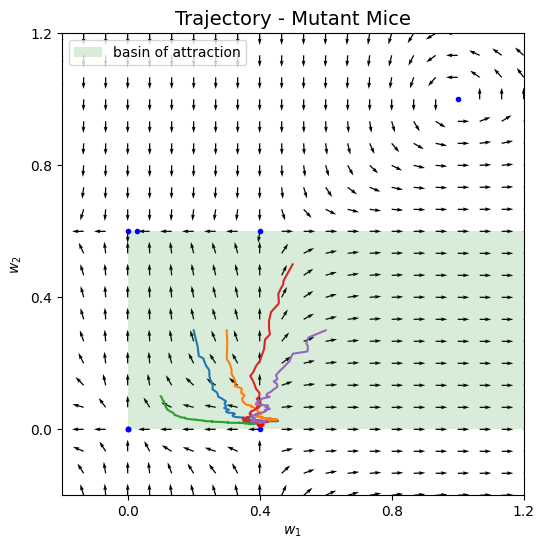

In [84]:
# zoom

initial_conditions = [(x,y) for x in np.linspace(-0.2, 1.2, 22) for y in np.linspace(-0.2,1.2, 22)]

fig, ax = plt.subplots(figsize=(6, 6))

critical_points = get_stationary_points(R1, R2)
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)

make_plot(ax, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectories)

fig.savefig('2a.pdf')